# 决策树
![](img/isea55.png)

上述的过程形成了一个树形的结构，这棵树的**叶子节点的部分，其实就是最终做出的决策**，这个决策实际上是对应聘者信息的一个分类，depth表示通过三次判断，将数据进行了一个分类。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

X = iris.data[:,2:] # 保留鸢尾花数据的后两个特征 
y = iris.target

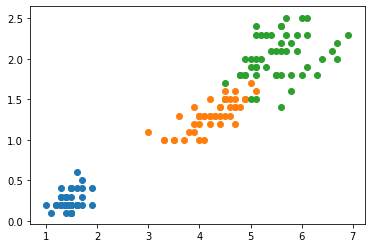

In [3]:
# 数据的可视化
plt.scatter(X[y == 0,0],X[y == 0,1])
plt.scatter(X[y == 1,0],X[y == 1,1])
plt.scatter(X[y == 2,0],X[y == 2,1])
plt.show()

In [4]:
from sklearn.tree import DecisionTreeClassifier

# 创建决策树的分类器， 设置决策树的深度是2 ,标准值设置为熵
dt_clf = DecisionTreeClassifier(max_depth = 2 ,criterion = "entropy")

dt_clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [5]:
# 绘制决策边界的函数
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)
    

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  app.launch_new_instance()


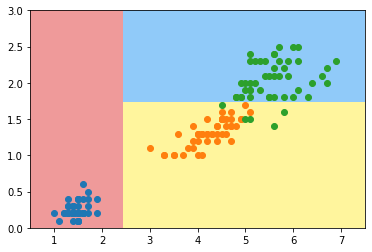

In [6]:
# 绘制决策边界
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])

# 将三中类型的三种类型的散点图绘制在图像上
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

#### 来看一下我们绘制的决策树是一颗什么样子的决策树
当前的决策树有两个特征：维度和阈值，比如在根节点的时候，选择x这个维度和2.4这个阈值，判断数据在x这个维度是大于2.4还是小于2.4，在第二个节点，选择y这个维度和1.8这个维度，来进行分类。
![](img/decision-tree/dt1.png)

关于决策树：
* 非参数学习算法
* 可以解决分类问题
* 天然的可以解决多分类问题
* 可以解决回归问题（落在叶子节点的所有样本的平均值作为回归问题的预测值）
* 具有很好的解释性（信用卡评级（拖延支付，驾照考分两个维度），阈值是3、8，结果信用卡评级被定为C级）

构建决策树的关键问题，在每个节点上都是一个判断条件，需要知道以下的两个信息：
* 每个节点对数据的哪个维度做划分（是x还是y）？
* （如果我们确定是哪个维度，具体的在）某个维度在哪个值上做划分？
下面使用计算信息熵的方法来解决这两个问题

### 信息熵
熵在信息论中代表着随机变量的不确定度的度量；熵越大，数据的不确定性程度越大；熵越小，数据的不确定性程度越小。
**信息熵的公式**

$$\mathrm{H} (X)=\sum _{{i}}{{\mathrm  {P}}(x_{i})\,{\mathrm  {I}}(x_{i})}=-\sum _{{i}}{{\mathrm  {P}}(x_{i})\log _{b}{\mathrm  {P}}(x_{i})},$$

如果我们的数据类别只有两类的话，一类占的比例是x，那么另外一类占的比例是（1-x）所以就有下面的公式：
$$\mathrm{H} (X)=-\ _{{}}{{\mathrm  {}}(x)\log _{}{\mathrm {}}(x)}-\ _{{}}{{\mathrm  {}}(1-x)\log _{}{\mathrm {}}(1-x)},$$

In [8]:
import numpy as np
import matplotlib.pyplot as ply

In [9]:
def entroypy(p):
    return -p * np.log(p) - (1 - p) * np.log(1-p) # 可以处理向量

In [11]:
x = np.linspace(0.01,0.99,200)

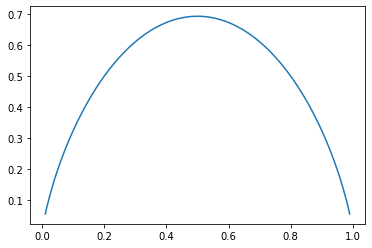

In [12]:
plt.plot(x,entroypy(x))
plt.show()

在p取值到0.5的时候，信息熵是最大的，也即不确定性最大，当全部都是某一类的时候，也就消除了不确定性，即信息熵为0，不确定性没有了。

和决策树：我们在每一个节点上都希望在某个维度上基于某个阈值进行划分，我们在划分之后让我们的数据划分成两部分只有，相应的系统整体的信息熵降低。

任务就是：在每一个节点上找到某个维度，和该维度上的取值，根据这个维度这个取值对数据进行划分，划分之后，信息熵是所有其他划分的方式中，熵是最小的。如何找到这个划分呢？只需要做一次网格搜索。

## 使用信息熵寻找最优划分


In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
# 绘制决策边界的函数
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)
    

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  app.launch_new_instance()


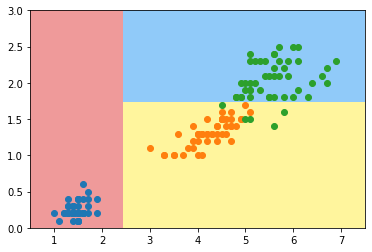

In [18]:
# 绘制决策边界
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])

# 将三中类型的三种类型的散点图绘制在图像上
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

### 模拟使用信息熵进行划分

In [20]:
# X表示特征，y表示分类的输出，d表示维度，value是阈值 ，基于d维度，value值进行划分

def split(X, y, d, value):
    index_a = (X[:,d] <= value)
    index_b = (X[:,d] > value)
    # 返回分类的两中数据和对相应的y值
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [21]:
from collections import Counter
from math import log

# 计算熵，y中包含了数据分成了哪些类别，数据 一共有哪些类别每个类别的比例是多少
def entropy(y):
    # 对于y值形成一个字典，key是y的取值，value是当前分类的个数
    counter = Counter(y)
    res = 0.0
    for num in counter.values():
        p = num / len(y)
        res += -p * log(p)
    return res

In [22]:
# 当前节点对应的样本数据X,y
def try_split(X,y):
    # 初始化为正无穷的值，每次都去寻找更小的熵
    best_entropy = float('inf')
    # 寻找最好的维度，最好的value
    best_d,best_v = -1,-1
    # 在X的维度上进行一个穷搜
    for d in range(X.shape[1]):
        # 接下来是对当前维度上的阈值进行划分，可选的每两个样本点在d这个维度上中间的那个值
        # 首先对样本在d维度上的排序
        sorted_index = np.argsort(X[:,d])
        for i in range(1,len(X)):
            if X[sorted_index[i - 1],d] != X[sorted_index[i],d]:
                v = (X[sorted_index[i - 1],d] + X[sorted_index[i],d]) / 2
                # 对d，v进行划分，并获取左右子树
                X_l,X_r,y_l,y_r = split(X,y,d,v)
                e = entropy(y_l) + entropy(y_r)
                if e < best_entropy:
                    best_entropy,best_d,best_v = e,d,v
    return best_entropy,best_d,best_v

In [24]:
best_entropy,best_d,best_v = try_split(X,y)
print("best_entropy =" ,best_entropy)
print("best_d =" ,best_d)
print("best_v =" ,best_v)

best_entropy = 0.6931471805599453
best_d = 0
best_v = 2.45


上述是对数据最原始的划分结果，第0个维度，也即x轴，2.45的位置进行划分，接下来对划分之后数据是什么样子，进行一个存储

In [25]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [29]:
# 查看左子树的信息熵
entropy(y1_l)

0.0

这里发现信息熵是0，这表示本次划分成功的将一类所有的数据都划分到了左边（如上面得到的决策边界的图像）

In [31]:
# 查看右子树的信息熵
entropy(y1_r)

0.6931471805599453

对于右子树，还可以进行划分

In [32]:
best_entropy2, best_d2, best_v2 = try_split(X1_r, y1_r)
print("best_entropy =", best_entropy2)
print("best_d =", best_d2)
print("best_v =", best_v2)

best_entropy = 0.4132278899361904
best_d = 1
best_v = 1.75


在第一个维度，1.75阈值位置进行划分，可以让我们的信息熵降低到最低 ，可以在上面的图中查看到，表现出来是一个横线。

查看第二次划分之后的数据和对应的信息熵

In [33]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [34]:
entropy(y2_l)

0.30849545083110386

### 基尼系数

$G = 1 - \sum_{i=1}^{k}p_i^2$

由基尼系数的公式来看，和信息熵一样能够衡量数据的不确定性，假设只有二分类的时候，公式为下面这个样子：

$G = 1 - x - (1-x)^2$

$G = -2x^2 + 2x $

这是一个二次曲线，在二分之一的时候，取到最大值，不确定性的程度最大


In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target

In [38]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=2, criterion="gini", random_state=42)
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [39]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*200)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*200)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

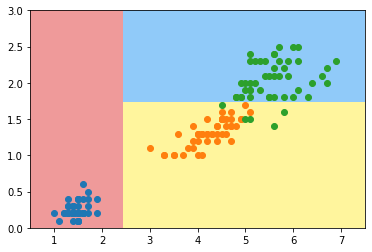

In [40]:
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

### 模拟使用基尼系数进行划分

In [41]:
from collections import Counter
from math import log

def split(X, y, d, value):
    index_a = (X[:,d] <= value)
    index_b = (X[:,d] > value)
    return X[index_a], X[index_b], y[index_a], y[index_b]

def gini(y):
    counter = Counter(y)
    res = 1.0
    for num in counter.values():
        p = num / len(y)
        res -= p**2
    return res

def try_split(X, y):
    
    best_g = float('inf')
    best_d, best_v = -1, -1
    for d in range(X.shape[1]):
        sorted_index = np.argsort(X[:,d])
        for i in range(1, len(X)):
            if X[sorted_index[i], d] != X[sorted_index[i-1], d]:
                v = (X[sorted_index[i], d] + X[sorted_index[i-1], d])/2
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                p_l, p_r = len(X_l) / len(X), len(X_r) / len(X)
                g = p_l * gini(y_l) + p_r * gini(y_r)
                if g < best_g:
                    best_g, best_d, best_v = g, d, v
                
    return best_g, best_d, best_v

In [42]:
best_g, best_d, best_v = try_split(X, y)
print("best_g =", best_g)
print("best_d =", best_d)
print("best_v =", best_v)

best_g = 0.3333333333333333
best_d = 0
best_v = 2.45


In [43]:
# 使用split真正的对数据进行划分
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [44]:
gini(y1_l)

0.0

In [45]:
gini(y1_r)

0.5

In [46]:
best_g2, best_d2, best_v2 = try_split(X1_r, y1_r)
print("best_g =", best_g2)
print("best_d =", best_d2)
print("best_v =", best_v2)

best_g = 0.1103059581320451
best_d = 1
best_v = 1.75


In [47]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [48]:
gini(y2_l)

0.1680384087791495

In [49]:
gini(y2_r)

0.04253308128544431

### 信息熵 VS 基尼系数

* 信息熵的计算比基尼系数稍慢
* sk-learn 中默认使用基尼系数

大多数情况下，二者没有特别的效果优劣

### CART (classification and regression tree)
到目前为止我们得到的决策树，既可以解决分类问题。这种实现是根据一个维度d和某一个阈值v进行二分，在sk-learn中的决策树的实现都是CART，出了CART这种实现，还有ID3，C4.5,C5.0其他种的实现。

在基于cart方式形成的决策树中，每一次做决策的过程时间复杂度是$O(log_2m)$ m是样本个数（也即为预测的复杂度）；而训练的复杂度是：$O(n*m*log_2m)$

和所有的非参数学习算法一样，决策树也非常容易发生过拟合，所以需要剪枝（降低决策树的复杂度，解决过拟合问题）。比如我们在设置树的高度，就是一种剪枝操作。

### 决策树的超参数

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
from sklearn import datasets

# 生成非线性数据
X, y = datasets.make_moons(noise=0.25, random_state=666)

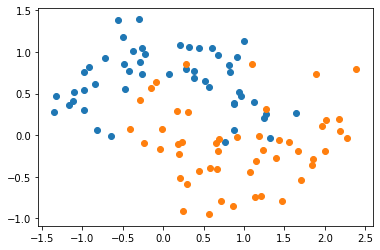

In [53]:
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()


In [56]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()

# 如果不传参数，默认划分节点的标准就是基尼系数，深度不做限定，划分到最后是基尼系数是0
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
# 绘制决策边界的函数
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


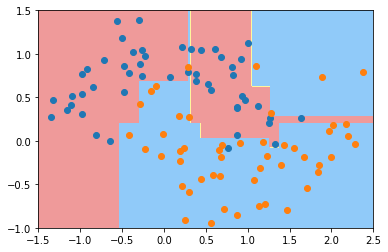

In [61]:
plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

显而易见，这里发生了过拟合

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


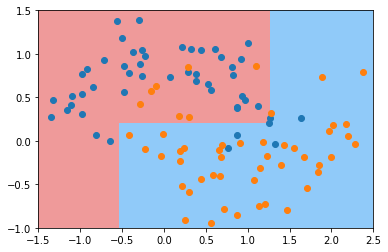

In [60]:
# 在传入的参数的情况下，判断决策边界
dt_clf2 = DecisionTreeClassifier(max_depth=2)
dt_clf2.fit(X, y)

plot_decision_boundary(dt_clf2, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

这里又有一些欠拟合了

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


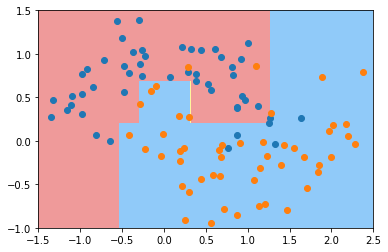

In [62]:
# 当我们的节点有多少个样本点的时候，才对这个节点继续拆分下去,该值太大，
# 会发生欠拟合，太小会发生过拟合
dt_clf3 = DecisionTreeClassifier(min_samples_split=10)
dt_clf3.fit(X, y)

plot_decision_boundary(dt_clf3, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


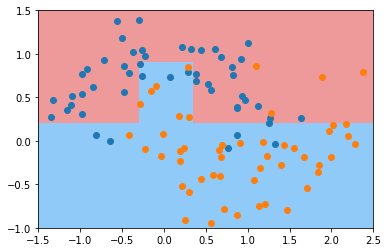

In [63]:
# 对于我们的叶子节点来说，至少要有几个样本点，为1 的时候会发生过拟合
dt_clf4 = DecisionTreeClassifier(min_samples_leaf=6)
dt_clf4.fit(X, y)

plot_decision_boundary(dt_clf4, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


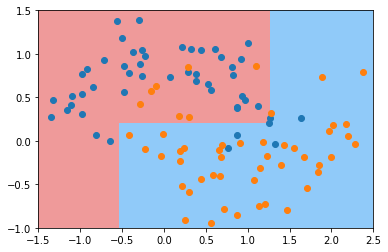

In [64]:
# 决策树的叶子节点，最多有多少个，如果太大，就会发生过拟合
dt_clf5 = DecisionTreeClassifier(max_leaf_nodes=4)
dt_clf5.fit(X, y)

plot_decision_boundary(dt_clf5, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

关于决策树，超参数，参考官网

### 决策树解决回归问题

这里可以使用某一个类别的均值来作为回归的预测值

In [65]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
from sklearn import datasets

boston = datasets.load_boston()
X = boston.data
y = boston.target

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [68]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [69]:

dt_reg.score(X_test, y_test)

0.5899493774449903

In [70]:
dt_reg.score(X_train, y_train)

1.0

这里的评分居然是1，很明显这里发生了过拟合。

### 决策树的局限性

决策树的局限性很明显：只能产生横平竖直的决策边界，不会产生一条斜线。

In [71]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target

In [73]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [74]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*200)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*200)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


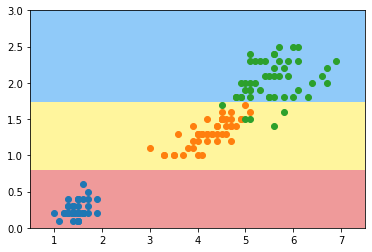

In [75]:
plot_decision_boundary(tree_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

In [76]:
# 删除一个样本点，重新预测
X_new = np.delete(X, 138, axis=0)
y_new = np.delete(y, 138)

In [78]:
X_new.shape

(149, 2)

In [77]:
tree_clf2 = DecisionTreeClassifier(max_depth=2, criterion="entropy")
tree_clf2.fit(X_new, y_new)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


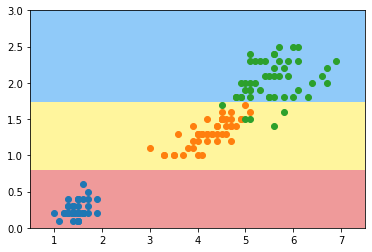

In [79]:

plot_decision_boundary(tree_clf2, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

这里可以发现仅仅删除一个点，决策边界就发生了很大的变化，可以发现决策树作为一个非参数学习方法，可能对个别的样本点非常敏感。

但是决策树往往不是单独使用的，因为在机器学习领域，会使用决策树创建随机森林的算法，而随机森林算法可以得到很好的学习结果。